# 🛡️ Malicious Domain Detection via RDAP Data Analysis and Transformer Modeling

## Brief Description

This notebook focuses on selecting the proper features for the detection of **malicious domains** (phishing, malware, etc.) using metadata from RDAP records. The workflow is organized into two main phases:

- Phase 1: RDAP JSON Preprocessing and Flattening

- Phase 2: Textual Feature Analysis for Model Input

---

## ✅ Outcome

By the end of this notebook:
- You will have a clean, analysis-ready RDAP dataset.
- You will understand which RDAP fields are most discriminative.
- You’ll be ready to feed selected fields into a transformer model to classify domains as **malicious** or **benign** with improved efficiency.

---


# Phase 1: RDAP JSON Preprocessing and Flattening

**Goal:**  
Prepare RDAP data for analysis by transforming MongoDB-exported JSON files into a structured tabular format.

**Input Format:**
- A JSON file where each line represents a document containing:
  - `"domain_name"`: the domain string.
  - `"rdap"`: a nested object with registration data.

**Processing Steps:**
1. Load each line from the JSON file into memory.
2. Flatten the nested `"rdap"` object using `pandas.json_normalize`.
3. Drop the MongoDB-generated `"_id"` field.
4. Optionally, clean up column names by removing the `rdap.` prefix.

**Output:**
A `pandas.DataFrame` where each row represents a domain, and columns include all flattened RDAP metadata fields — ready for further analysis.


In [1]:
import json
import random 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import HTML
from typing import Optional, List, Dict
from scipy.stats import chi2_contingency

In [2]:


def render_dataframe(df, max_rows=100, max_cols=50):
    styles = [
        dict(selector="th", props=[("max-width", "200px")]),
        dict(selector="td", props=[("max-width", "200px"), ("overflow", "auto"), ("text-overflow", "ellipsis")]),
    ]
    return HTML(df.head(max_rows).style.set_table_styles(styles).set_table_attributes('style="display:inline-block;overflow:auto;max-height:500px;"').to_html())

def read_rdap_json_file(file_path: str) -> pd.DataFrame:
    # Read the JSON file line by line
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]

    # Flatten the JSON structure; each nested key from 'rdap' becomes a column like 'rdap.handle', etc.
    df = pd.json_normalize(data, sep='.')

    # Drop _id columns 
    df = df.drop(columns=[col for col in df.columns if col.startswith('_id')])

    # Remove the "rdap." prefix from column names for clarity
    df.columns = [col.replace('rdap.', '') for col in df.columns]
    return df 

# Construct the path to the JSON file relative to this script's location.
script_path = Path.cwd()
# Go up 3 levels to the project root (from transformers/data -> transformers -> project_root)
project_root = script_path.parent.parent

In [3]:
def _sample_jsonl_lines(file_path: str, sample_size: int, total_lines: int, seed: int) -> List[Dict]:
    """
    Randomly samples lines from a JSONL file using a 2-pass strategy.

    Args:
        file_path (str): Path to the JSONL file.
        sample_size (int): Number of lines to sample.
        total_lines (int): Total number of lines in the file.
        seed (int): Random seed for reproducibility.

    Returns:
        List[Dict]: List of sampled JSON objects.
    """
    random.seed(seed)
    selected_indices = set(random.sample(range(total_lines), sample_size))
    data = []

    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i in selected_indices:
                data.append(json.loads(line))
            if len(data) >= sample_size:
                break  # Optional: early exit

    return data

def read_rdap_json_file_to_df(file_path: str, sample_size: Optional[int] = None, seed: int = 42) -> pd.DataFrame:
    """
    Reads a JSONL RDAP file and returns a flattened pandas DataFrame.
    If sample_size is provided and smaller than total lines, randomly samples those lines.

    Args:
        file_path (str): Path to the JSONL file.
        sample_size (int, optional): Number of records to sample. If None or exceeds file size, loads full file.
        seed (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: Flattened DataFrame with 'domain_name' and RDAP fields.
    """
    with open(file_path, 'r') as f:
        total_lines = sum(1 for _ in f)

    if sample_size is None or sample_size >= total_lines:
        with open(file_path, 'r') as f:
            data = [json.loads(line) for line in f]
    else:
        data = _sample_jsonl_lines(file_path, sample_size, total_lines, seed)

    df = pd.json_normalize(data, sep='.')
    df = df.drop(columns=[col for col in df.columns if col.startswith('_id')], errors='ignore')
    df.columns = [col.replace('rdap.', '') for col in df.columns]

    return df


### Benign

In [4]:
benign_file_path = project_root / "datasets" / "benign" / "benign_2312_anonymized_rdap_2024.json"
benign_df = read_rdap_json_file_to_df(benign_file_path, sample_size=160_000)
render_dataframe(benign_df)

,domain_name,handle,name,whois_server,terms_of_service_url,copyright_notice,description,last_changed_date.$date,registration_date.$date,expiration_date.$date,url,entities.registrant,entities.abuse,entities.admin,entities.registrar,nameservers,status,registration_date,expiration_date,entities.technical,entities.administrative,entities.billing,dnssec,rdap,last_changed_date,entities.sponsor,entities.zone,entities.tech,entities.reseller
0,00000fs3085d.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0000100b00e9.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0000100q012c.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0000102n02c4.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0000102n02d5.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,0000102n03d3.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,0000102n0434.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,000010560066.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,0000105600be.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,000010640021.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [5]:
benign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   domain_name              160000 non-null  object 
 1   handle                   104921 non-null  object 
 2   name                     104921 non-null  object 
 3   whois_server             104921 non-null  object 
 4   terms_of_service_url     104921 non-null  object 
 5   copyright_notice         104921 non-null  object 
 6   description              104921 non-null  object 
 7   last_changed_date.$date  87207 non-null   object 
 8   registration_date.$date  96981 non-null   object 
 9   expiration_date.$date    91816 non-null   object 
 10  url                      104921 non-null  object 
 11  entities.registrant      103373 non-null  object 
 12  entities.abuse           99417 non-null   object 
 13  entities.admin           63215 non-null   object 
 14  enti

### Phishing

In [6]:
# Now build the path to the JSON file in datasets/malware/
# json_file_path = project_root / "datasets" / "phishing" / "phishing_strict_rdap_2024.json"
json_file_path = project_root / "datasets" / "phishing" / "phishing_strict_rdap_2024.json"
phish_df = read_rdap_json_file_to_df(json_file_path)
render_dataframe(phish_df)

,domain_name,handle,name,whois_server,terms_of_service_url,copyright_notice,description,last_changed_date.$date,registration_date.$date,expiration_date.$date,url,entities.registrar,entities.abuse,nameservers,status,dnssec,entities.registrant,entities.admin,expiration_date,last_changed_date,registration_date,rdap,entities.technical,entities.administrative,entities.billing,entities.sponsor,entities.zone,entities.reseller,entities.tech
0,conflrma57843.com,2876141922_DOMAIN_COM-VRSN,CONFLRMA57843.COM,,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,,[],2024-04-27T11:19:45Z,2024-04-27T11:17:07Z,2025-04-27T11:17:07Z,https://rdap.verisign.com/com/v1/domain/CONFLRMA57843.COM,"[{'handle': '1250', 'type': 'entity', 'name': 'OwnRegistrar, Inc.'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['AISHA.NS.CLOUDFLARE.COM', 'ROMMY.NS.CLOUDFLARE.COM']",['active'],False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,www.zgahdjm.com,,zgahdjm.com,,,,[],2024-04-02T07:05:11Z,2021-04-01T06:22:41Z,2025-04-01T06:22:41Z,,[{'name': 'Gname.com Pte. Ltd.'}],[{'email': ''}],"['JM1.DNS.COM', 'JM2.DNS.COM']",['client transfer prohibited'],nan,[{'name': 'Redacted for privacy'}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,attt.pages.dev,,pages.dev,,,,[],2023-09-04T18:15:07Z,2020-09-02T02:33:29Z,2026-09-02T02:33:29Z,,"[{'name': 'CloudFlare, Inc.'}]",[{'email': ''}],"['ADI.NS.CLOUDFLARE.COM', 'KARL.NS.CLOUDFLARE.COM']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",nan,[{'name': 'DATA REDACTED'}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,chermate.weeblysite.com,,weeblysite.com,,,,[],2022-12-19T08:40:44Z,2012-12-19T04:07:22Z,2023-12-19T04:07:22Z,,[{'name': 'SafeNames Ltd.'}],[{'email': ''}],"['DNS1.P08.NSONE.NET', 'DNS2.P08.NSONE.NET', 'DNS3.P08.NSONE.NET', 'DNS4.P08.NSONE.NET']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",nan,"[{'name': 'Weebly, Inc.'}]",[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,allegrolokalnie.oferta73.pl,,oferta73.pl,,,,[],2024-04-04T21:40:53Z,2024-03-29T22:44:41Z,nan,,[{'name': 'Hosting Concepts B.V.'}],[{'email': ''}],"['NS1.DNS-SUSPENDED.COM', 'NS2.DNS-SUSPENDED.COM']",[],nan,[{'name': ''}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,validarnavegador.com,2813464537_DOMAIN_COM-VRSN,VALIDARNAVEGADOR.COM,,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,,[],2023-10-27T01:36:15Z,2023-09-13T11:37:16Z,2024-09-13T11:37:16Z,https://rdap.verisign.com/com/v1/domain/VALIDARNAVEGADOR.COM,"[{'handle': '1910', 'type': 'entity', 'name': 'CloudFlare, Inc.'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['ISABEL.NS.CLOUDFLARE.COM', 'JAMES.NS.CLOUDFLARE.COM']","['client hold', 'client transfer prohibited']",False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,contraato.salonqs.cl,,contraato.salonqs.cl,,,,[],nan,nan,nan,,[{'name': 'nic.cl'}],[{'email': ''}],[],[],nan,[{'name': ''}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,assets-project-cloud.reconfirmation-zip.workers.dev,,workers.dev,,,,[],2022-12-15T00:03:23Z,2019-02-08T20:36:47Z,2025-02-08T20:36:47Z,,"[{'name': '101domain, Inc.'}]",[{'email': ''}],"['CLYDE.NS.CLOUDFLARE.COM', 'SOFIA.NS.CLOUDFLARE.COM']",['client transfer prohibited'],nan,[{'name': ''}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,urkedxs.com,2866061828_DOMAIN_COM-VRSN,URKEDXS.COM,,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,,[],2024-03-23T11:50:51Z,2024-03-23T11:47:25Z,2025-03-23T11:47:25Z,https://rdap.verisign.com/com/v1/domain/URKEDXS.COM,"[{'handle': '1599', 'type': 'entity', 'name': 'Alibaba Cloud Computing Ltd. d/b/a HiChina (www.net.cn)'}]","[{'type': 'entity', 'name': '', 'email': 'DomainAbuse@service.aliyun.com'}]","['DNS29.HICHINA.COM', 'DNS30.HICHINA.COM']",['activ

In [7]:
phish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164425 entries, 0 to 164424
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   domain_name              164425 non-null  object 
 1   handle                   150816 non-null  object 
 2   name                     150816 non-null  object 
 3   whois_server             150816 non-null  object 
 4   terms_of_service_url     150816 non-null  object 
 5   copyright_notice         150816 non-null  object 
 6   description              150816 non-null  object 
 7   last_changed_date.$date  135925 non-null  object 
 8   registration_date.$date  147932 non-null  object 
 9   expiration_date.$date    145056 non-null  object 
 10  url                      150816 non-null  object 
 11  entities.registrar       149412 non-null  object 
 12  entities.abuse           147998 non-null  object 
 13  nameservers              150816 non-null  object 
 14  stat

# Phase 2: Textual Feature Analysis for Model Input

**Goal:**  
Identify the most informative **textual RDAP fields** for input into a transformer-based model for malicious domain classification.

**Steps:**
1. **Handle missing values**
2. **Text Field Extraction:**  
   Collect all string-based fields from the flattened DataFrame.
3. **Feature Engineering:**  
   For each field, compute numerical representations such as:
   - String length
   - Character entropy
   - Alphanumeric ratios
   - Word count, etc.
4. **Statistical Evaluation:**  
   - Visualize distributions (histograms, KDEs).
   - Perform hypothesis testing (e.g., t-test, Mann-Whitney U) to assess significance between malicious and benign domains.
5. **Feature Selection:**  
   Rank and select fields that show strong statistical signals or unique distribution patterns across classes.


## Handling of missing values

### Columns with any NaN (missing values)
Before hadnling the Nan values, it is clear that some columns appear that they are not empty, because they do not contain NaN values. But this is false, because by analyzing the columns, it is clear that some of them contain empty strings '' or empty lists '[]'. Therefore, for better analysis will be these values replaced by NaN.

In [8]:
# Replace empty strings or strings with only whitespace with NaN
benign_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
phish_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

def convert_empty_list(val):
    if isinstance(val, list) and len(val) == 0:
        return np.nan
    return val

# Apply this function to every cell in the DataFrame
benign_df[:] = benign_df.applymap(convert_empty_list)
phish_df[:] = phish_df.applymap(convert_empty_list)
# Replace empty lists or strings with only whitespace with NaN
# benign_df.replace(r'^\[\s*\]$', np.nan, regex=True, inplace=True) 
# phish_df.replace(r'^\[\s*\]$', np.nan, regex=True, inplace=True)

/tmp/ipykernel_731661/3636527242.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  benign_df[:] = benign_df.applymap(convert_empty_list)
/tmp/ipykernel_731661/3636527242.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  phish_df[:] = phish_df.applymap(convert_empty_list)


In [9]:
# Benign
nan_columns = benign_df.columns[benign_df.isna().any()].tolist()
print("Benign:")
print(f"Number of columns containing any NaN value: {len(nan_columns)}")
print(f"Total number of columns: {len(benign_df.columns.to_list())}")
print("---------------------------------------------------------------")
#Phishing
nan_columns = phish_df.columns[phish_df.isna().any()].tolist()
print("Phishing:")
print(f"Number of columns containing any NaN value: {len(nan_columns)}")
print(f"Total number of columns: {len(phish_df.columns.to_list())}")

Benign:
Number of columns containing any NaN value: 28
Total number of columns: 29
---------------------------------------------------------------
Phishing:
Number of columns containing any NaN value: 28
Total number of columns: 29


### Columns That Are Fully Empty (All Values Are NaN)
These columns can be fully dropped

In [10]:
# Benign
fully_nan_benign = benign_df.columns[benign_df.isna().all()].tolist()
print("Benign:")
print("Columns with only NaN values:", fully_nan_benign)
print("---------------------------------------------------------------")

# Phishing
fully_nan_phishing = phish_df.columns[phish_df.isna().all()].tolist()
print("Phishing:")
print("Columns with only NaN values:", fully_nan_phishing)

Benign:
Columns with only NaN values: ['registration_date', 'expiration_date', 'rdap', 'last_changed_date']
---------------------------------------------------------------
Phishing:
Columns with only NaN values: ['expiration_date', 'last_changed_date', 'registration_date', 'rdap']


In [11]:
# Benign
print("Benign:") 
print("Before:", benign_df.shape)
benign_df.drop(columns=fully_nan_benign, inplace=True, errors="ignore")
print("After:", benign_df.shape)
print("---------------------------------------------------------------")
# Phishing
print("Phishing:") 
print("Before:", phish_df.shape)
phish_df.drop(columns=fully_nan_phishing, inplace=True, errors="ignore")
print("After:", phish_df.shape)

Benign:
Before: (160000, 29)
After: (160000, 25)
---------------------------------------------------------------
Phishing:
Before: (164425, 29)
After: (164425, 25)


In [12]:
missing_counts = benign_df.isna().sum()
print(missing_counts[missing_counts > 0])

handle                     117539
name                        55079
whois_server               147117
terms_of_service_url       123591
copyright_notice           159777
description                159958
last_changed_date.$date     72793
registration_date.$date     63019
expiration_date.$date       68184
url                        120847
entities.registrant         56627
entities.abuse              60583
entities.admin              96785
entities.registrar          55356
nameservers                 60054
status                      66016
entities.technical         122912
entities.administrative    122764
entities.billing           147344
dnssec                     117449
entities.sponsor           158864
entities.zone              159814
entities.tech              159155
entities.reseller          159987
dtype: int64


In [13]:
# Benign
print(benign_df.info())
# Phishing
print(phish_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   domain_name              160000 non-null  object
 1   handle                   42461 non-null   object
 2   name                     104921 non-null  object
 3   whois_server             12883 non-null   object
 4   terms_of_service_url     36409 non-null   object
 5   copyright_notice         223 non-null     object
 6   description              42 non-null      object
 7   last_changed_date.$date  87207 non-null   object
 8   registration_date.$date  96981 non-null   object
 9   expiration_date.$date    91816 non-null   object
 10  url                      39153 non-null   object
 11  entities.registrant      103373 non-null  object
 12  entities.abuse           99417 non-null   object
 13  entities.admin           63215 non-null   object
 14  entities.registrar  

<Figure size 1200x600 with 0 Axes>

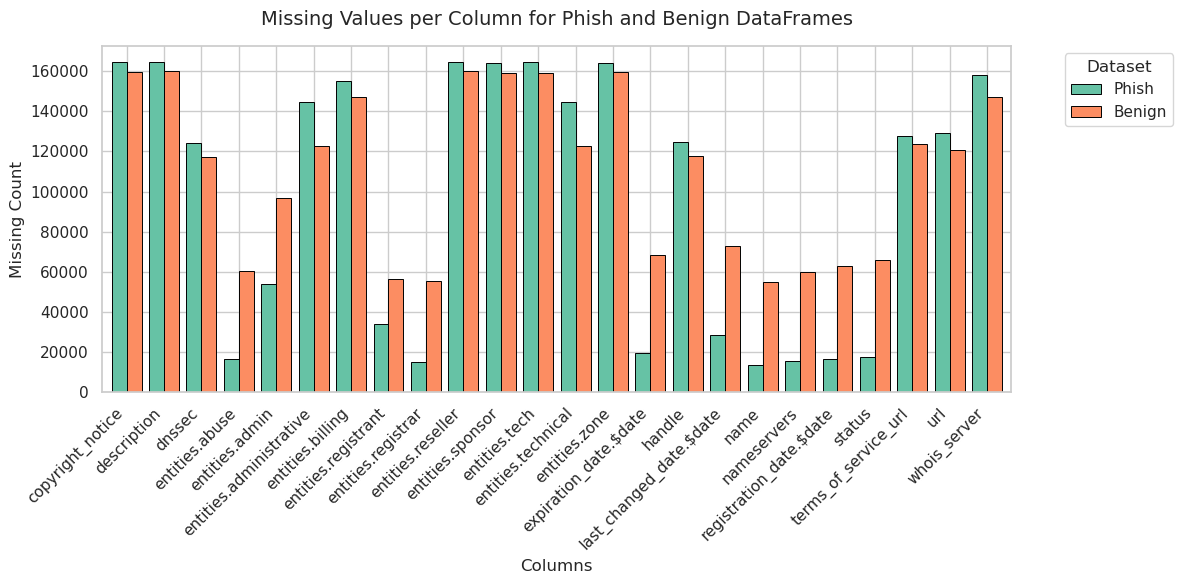

In [14]:
# 1. Calculate missing counts
missing_phish = phish_df.isna().sum()
missing_benign = benign_df.isna().sum()

# 2. Combine the counts into one DataFrame
missing_counts = pd.DataFrame({
    'Phish': missing_phish,
    'Benign': missing_benign
})

# 3. (Optional) Filter to only columns with missing values
missing_counts = missing_counts[(missing_counts['Phish'] > 0) | (missing_counts['Benign'] > 0)]

# 4. Use Seaborn to set a modern style/theme
sns.set_theme(style="whitegrid")

# 5. Create a grouped bar chart
plt.figure(figsize=(12, 6))

# Here, we specify a palette from Seaborn (e.g., "Set2", "husl", "deep", etc.)
# We'll pick two colors from a palette for 'Phish' and 'Benign'.
colors = sns.color_palette("Set2", n_colors=2)

# missing_counts.plot.bar returns an Axes object, so we capture it
ax = missing_counts.plot(
    kind='bar',
    color=colors,
    width=0.8,
    edgecolor='black',
    linewidth=0.7,
    figsize=(12, 6)
)

# 6. Customize labels and title
ax.set_title("Missing Values per Column for Phish and Benign DataFrames", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Count", fontsize=12)

# 7. Improve x-axis label rotation and spacing
plt.xticks(rotation=45, ha='right')

# 8. Move the legend outside the plot (optional)
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

# 9. Adjust layout so everything fits
plt.tight_layout()

# 10. Show the plot
plt.show()


<Figure size 1200x600 with 0 Axes>

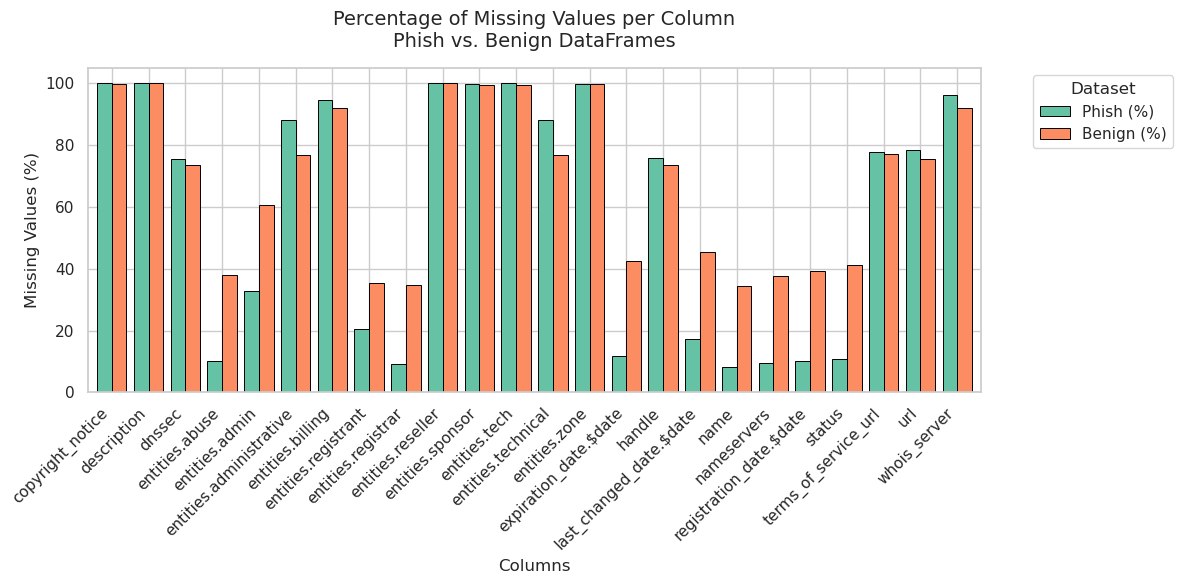

In [15]:
# 1. Calculate the proportion (percentage) of missing values per column
phish_missing_pct = phish_df.isna().sum() / len(phish_df) * 100
benign_missing_pct = benign_df.isna().sum() / len(benign_df) * 100

# 2. Combine into one DataFrame
missing_pct = pd.DataFrame({
    'Phish (%)': phish_missing_pct,
    'Benign (%)': benign_missing_pct
})

# 3. (Optional) Filter to only columns that have missing values in at least one DataFrame
missing_pct = missing_pct[(missing_pct['Phish (%)'] > 0) | (missing_pct['Benign (%)'] > 0)]

# 4. Set a modern Seaborn theme
sns.set_theme(style="whitegrid")

# 5. Plot a grouped bar chart
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)
ax = missing_pct.plot(
    kind='bar',
    color=colors,
    width=0.8,
    edgecolor='black',
    linewidth=0.7,
    figsize=(12, 6)
)

# 6. Customize the title and labels
ax.set_title("Percentage of Missing Values per Column\nPhish vs. Benign DataFrames", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Values (%)", fontsize=12)

# 7. Improve x-axis label rotation
plt.xticks(rotation=45, ha='right')

# 8. Move the legend (optional)
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

# 9. Tight layout for readability
plt.tight_layout()

# 10. Display the plot
plt.show()


In [16]:
# Function to compute Cohen's h between two proportions
def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

results = {}

# Iterate over all columns (assuming both dataframes have the same columns)
for col in benign_df.columns:
    # Calculate the proportion of missing values for each group
    phish_missing_pct = phish_df[col].isna().sum() / len(phish_df)
    benign_missing_pct = benign_df[col].isna().sum() / len(benign_df)
    
    # Calculate Cohen's h (absolute value to focus on the magnitude of the difference)
    h_value = abs(cohens_h(phish_missing_pct, benign_missing_pct))
    
    results[col] = {
        'phish_missing_pct': phish_missing_pct,
        'benign_missing_pct': benign_missing_pct,
        "Cohen's h": h_value
    }

# Create a DataFrame for easier visualization and sort by effect size (largest differences first)
results_df = pd.DataFrame(results).T.sort_values("Cohen's h", ascending=False)
print("Cohen's h and missing percentages for each column:")
print(results_df)

# Set a threshold for a minimal effect size. Here, features with Cohen's h below this value are considered not informative.
threshold = 0.2

# Identify columns that have an effect size smaller than the threshold
features_to_drop = results_df[results_df["Cohen's h"] < threshold].index.tolist()

print("\nFeatures recommended to drop (Cohen's h < {}):".format(threshold))
print(features_to_drop)

Cohen's h and missing percentages for each column:
                         phish_missing_pct  benign_missing_pct  Cohen's h
status                            0.107034            0.412600   0.728501
expiration_date.$date             0.117798            0.426150   0.721873
registration_date.$date           0.100307            0.393869   0.712383
nameservers                       0.094712            0.375337   0.693152
entities.abuse                    0.099906            0.378644   0.682449
name                              0.082767            0.344244   0.670378
entities.registrar                0.091306            0.345975   0.643719
last_changed_date.$date           0.173331            0.454956   0.621775
entities.admin                    0.328119            0.604906   0.562303
entities.registrant               0.206441            0.353919   0.331008
entities.administrative           0.880158            0.767275   0.299825
entities.technical                0.880286            0.76820

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Helper function to handle arrays
def is_missing(x):
    """
    Return 1 if the value is considered missing, otherwise 0.
    Considers NaN, empty strings (after stripping), empty lists, and empty numpy arrays as missing.
    """
    # Check if x is an array or list and if it's empty
    if isinstance(x, (list, np.ndarray)):
        if len(x) == 0:
            return 1
        else:
            return 0
    # For scalar values, use pd.isna
    if pd.isna(x):
        return 1
    if isinstance(x, str) and x.strip() == "":
        return 1
    return 0

# -------------------------------
# Step 1: Combine the DataFrames
# -------------------------------
# Assume benign_df and malicious_df are your two dataframes.
benign_df['label'] = 0  # 0 for benign
phish_df['label'] = 1  # 1 for malicious

# Combine the two dataframes into one.
df = pd.concat([benign_df, phish_df], ignore_index=True)
print("Combined dataframe shape:", df.shape)

# -----------------------------------------------
# Step 2: Compute Missingness Indicator & Build Contingency Tables
# -----------------------------------------------
# List of columns to analyze (adjust as needed)
cols_to_check = [
    'handle', 'name', 'whois_server', 'terms_of_service_url', 'copyright_notice',
    'description', 'last_changed_date.$date', 'registration_date.$date',
    'expiration_date.$date', 'url', 'entities.registrant', 'entities.abuse',
    'entities.admin', 'entities.registrar', 'nameservers', 'status',
    'entities.technical', 'entities.administrative', 'entities.billing',
    'dnssec', 'entities.sponsor', 'entities.zone', 'entities.tech', 'entities.reseller'
]

# Dictionary to store results
missing_stats = {}

for col in cols_to_check:
    if col in df.columns:
        # Create a temporary missingness indicator series for the column.
        missing_indicator = df[col].apply(is_missing)
        overall_missing_rate = missing_indicator.mean()
        
        # Build a contingency table: rows = missing indicator, columns = label
        contingency = pd.crosstab(missing_indicator, df['label'])
        
        # Run chi-square test if both classes are present in the contingency table.
        if contingency.shape[1] == 2:
            chi2, p, dof, expected = chi2_contingency(contingency)
        else:
            p = 1.0  # Set non-significant if one of the classes is missing.
        
        missing_stats[col] = {
            'overall_missing_rate': overall_missing_rate,
            'chi2_p_value': p,
            'contingency_table': contingency
        }
        
        print(f"Column: {col}")
        print(f"  Overall Missing Rate: {overall_missing_rate:.2f}")
        print(f"  Chi-Square p-value: {p:.4f}")
        print(f"  Contingency Table:\n{contingency}\n")

# ------------------------------------------------------
# Step 3: Decide on Columns to Drop or Retain
# ------------------------------------------------------
# For example, drop columns if overall missing rate is above 90% and p-value > 0.05
columns_to_drop = []

for col, stats in missing_stats.items():
    if stats['overall_missing_rate'] > 0.90 and stats['chi2_p_value'] > 0.05:
        columns_to_drop.append(col)
        print(f"Candidate to drop: {col} (Missing rate: {stats['overall_missing_rate']:.2f}, p-value: {stats['chi2_p_value']:.4f})")

print("\nFinal list of columns to drop based on missingness and statistical test:")
print(columns_to_drop)


Combined dataframe shape: (324425, 26)
Column: handle
  Overall Missing Rate: 0.75
  Chi-Square p-value: 0.0000
  Contingency Table:
label        0       1
handle                
0        42461   39924
1       117539  124501

Column: name
  Overall Missing Rate: 0.21
  Chi-Square p-value: 0.0000
  Contingency Table:
label       0       1
name                 
0      104921  150816
1       55079   13609

Column: whois_server
  Overall Missing Rate: 0.94
  Chi-Square p-value: 0.0000
  Contingency Table:
label              0       1
whois_server                
0              12883    6180
1             147117  158245

Column: terms_of_service_url
  Overall Missing Rate: 0.77
  Chi-Square p-value: 0.0026
  Contingency Table:
label                      0       1
terms_of_service_url                
0                      36409   36689
1                     123591  127736

Column: copyright_notice
  Overall Missing Rate: 1.00
  Chi-Square p-value: 0.0000
  Contingency Table:
label          

In [18]:
# Set your missingness threshold (70% in this case)
missing_threshold = 0.70

# Calculate the fraction of missing values for each column in both DataFrames
phish_missing_pct = phish_df.isna().mean()
benign_missing_pct = benign_df.isna().mean()

# Identify columns exceeding the threshold in either dataset
phish_high_missing = phish_missing_pct[phish_missing_pct > missing_threshold].index
benign_high_missing = benign_missing_pct[benign_missing_pct > missing_threshold].index

# Combine into a single set (or list) of columns to drop
features_high_missing = set(phish_high_missing).union(set(benign_high_missing))

print("Features with missingness > 70% in at least one DataFrame:")
print(features_high_missing)


Features with missingness > 70% in at least one DataFrame:
{'entities.technical', 'entities.administrative', 'url', 'entities.reseller', 'entities.sponsor', 'handle', 'entities.tech', 'entities.billing', 'copyright_notice', 'description', 'entities.zone', 'terms_of_service_url', 'whois_server', 'dnssec'}


### Inspection of columns which should be dropped according to statistical analysis

In [19]:
for col in features_high_missing:
    print(benign_df[col].value_counts())
    print(phish_df[col].value_counts())
    print("---------------------------------------------------------------")

entities.technical
[{'type': 'entity'}]                                                                                                                                                                                                                                         28432
[{'type': 'entity', 'name': ''}]                                                                                                                                                                                                                              2237
[{'handle': 'REDACTED FOR PRIVACY', 'type': 'entity', 'name': 'REDACTED FOR PRIVACY', 'email': 'EMAIL REDACTED FOR PRIVACY'}]                                                                                                                                  404
[{'handle': 'OVH5-FRNIC', 'url': 'https://rdap.nic.fr/entity/OVH5-FRNIC', 'type': 'entity', 'whois_server': 'whois.ovh.com', 'name': '', 'email': 'tech@ovh.net', 'tel': '+33.899701761'}]                  

In [20]:
benign_df["description"].explode().dropna().unique()
phish_df["copyright_notice"].explode().dropna().value_counts()
benign_df["copyright_notice"].explode().dropna().value_counts()


copyright_notice
Auteursrechtvoorbehoud: Niets uit deze publicatie mag zonder voorafgaande uitdrukkelijke toestemming van SIDN worden verveelvoudigd, openbaar gemaakt, worden opgeslagen in een gegevensbestand of worden overgezonden, in welke vorm dan ook, elektronisch, mechanisch, door middel van opname of anderszins. Voor registrars geldt dit voorbehoud onverkort, behoudens redelijkerwijs noodzakelijke verveelvoudigingen of openbaarmakingen ten behoeve van de werkzaamheden van registrars, zoals vermeld in de 'Algemene voorwaarden voor registrars'. Elk gebruik van deze informatie voor commerci�le of reclamedoeleinden of soortgelijke activiteiten, is expliciet verboden en tegen overtreding van dat verbod zal worden opgetreden. SIDN verzoekt te worden ge�nformeerd bij constatering van dergelijke activiteiten of enig vermoeden daarvan. � SIDN BV, Auteurswet, geschriftenbescherming (art. 10 lid 1 sub 1)    223
Name: count, dtype: int64

In [21]:
def make_hashable(x):
    """
    Convert x into a hashable type.
    If x is a dict, convert it to a tuple of sorted key-value pairs.
    If x is a list, recursively convert each element.
    Otherwise, return x as-is.
    """
    if isinstance(x, dict):
        # Convert dictionary into a tuple of sorted key-value pairs
        return tuple(sorted((k, make_hashable(v)) for k, v in x.items()))
    elif isinstance(x, list):
        # Convert each element in the list and then make the list a tuple.
        return tuple(make_hashable(item) for item in x)
    else:
        return x

# Iterate over columns_to_drop and display unique values
for col in columns_to_drop:
    # Explode the column (if applicable), drop NA, and convert values to hashable types
    exploded_values = df[col].explode().dropna().apply(make_hashable)
    
    # Now get unique values and their counts
    unique_vals = exploded_values.value_counts()
    
    print(f"Unique values for column '{col}':")
    print(unique_vals)
    print("\n")


Unique values for column 'entities.reseller':
entities.reseller
((handle, RSR_44969-SIDN), (name, Cloud DNS Ltd), (type, entity), (url, https://rdap.sidn.nl/entity/RSR_44969-SIDN))                 4
((handle, RSR_11129-SIDN), (name, Mijndomein Hosting BV), (type, entity), (url, https://rdap.sidn.nl/entity/RSR_11129-SIDN))         4
((name, Cloud DNS Ltd), (type, entity))                                                                                              3
((handle, RSR_39953-SIDN), (name, Neostrada), (type, entity), (url, https://rdap.sidn.nl/entity/RSR_39953-SIDN))                     3
((handle, NOT APPLICABLE), (name, NAMECHEAP), (type, entity))                                                                        2
((handle, RSR_37854-SIDN), (name, TransIP), (type, entity), (url, https://rdap.sidn.nl/entity/RSR_37854-SIDN))                       2
((email, corp-gtld-transfers@cscinfo.com), (handle, LEX-N-R-5M3-1), (name, CSC Corporate Domains, Inc.), (type, entity))      

### Dropping the columns

In [22]:
columns_to_drop = list(features_high_missing) + ['name']
print("Columns to drop:")
print(columns_to_drop)

# Remove 'dnssec' from the list if it exists
if 'dnssec' in columns_to_drop:
    columns_to_drop.remove('dnssec')
    print(columns_to_drop)


# Drop the identified columns from the DataFrame
benign_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")
phish_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")

# Replace the Nans in the 'dnssec' column with 'False'
benign_df.loc[:, 'dnssec'] = benign_df['dnssec'].fillna('False')
phish_df.loc[:, 'dnssec'] = phish_df['dnssec'].fillna('False')


Columns to drop:
['entities.technical', 'entities.administrative', 'url', 'entities.reseller', 'entities.sponsor', 'handle', 'entities.tech', 'entities.billing', 'copyright_notice', 'description', 'entities.zone', 'terms_of_service_url', 'whois_server', 'dnssec', 'name']
['entities.technical', 'entities.administrative', 'url', 'entities.reseller', 'entities.sponsor', 'handle', 'entities.tech', 'entities.billing', 'copyright_notice', 'description', 'entities.zone', 'terms_of_service_url', 'whois_server', 'name']


In [23]:
render_dataframe(benign_df, max_rows=100, max_cols=50)

,domain_name,last_changed_date.$date,registration_date.$date,expiration_date.$date,entities.registrant,entities.abuse,entities.admin,entities.registrar,nameservers,status,dnssec,label
0,00000fs3085d.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
1,0000100b00e9.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
2,0000100q012c.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
3,0000102n02c4.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
4,0000102n02d5.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
5,0000102n03d3.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
6,0000102n0434.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
7,000010560066.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
8,0000105600be.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
9,000010640021.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0


In [24]:
render_dataframe(phish_df, max_rows=100, max_cols=50)

,domain_name,last_changed_date.$date,registration_date.$date,expiration_date.$date,entities.registrar,entities.abuse,nameservers,status,dnssec,entities.registrant,entities.admin,label
0,conflrma57843.com,2024-04-27T11:19:45Z,2024-04-27T11:17:07Z,2025-04-27T11:17:07Z,"[{'handle': '1250', 'type': 'entity', 'name': 'OwnRegistrar, Inc.'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['AISHA.NS.CLOUDFLARE.COM', 'ROMMY.NS.CLOUDFLARE.COM']",['active'],False,nan,nan,1
1,www.zgahdjm.com,2024-04-02T07:05:11Z,2021-04-01T06:22:41Z,2025-04-01T06:22:41Z,[{'name': 'Gname.com Pte. Ltd.'}],[{'email': ''}],"['JM1.DNS.COM', 'JM2.DNS.COM']",['client transfer prohibited'],False,[{'name': 'Redacted for privacy'}],[{'name': ''}],1
2,attt.pages.dev,2023-09-04T18:15:07Z,2020-09-02T02:33:29Z,2026-09-02T02:33:29Z,"[{'name': 'CloudFlare, Inc.'}]",[{'email': ''}],"['ADI.NS.CLOUDFLARE.COM', 'KARL.NS.CLOUDFLARE.COM']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",False,[{'name': 'DATA REDACTED'}],[{'name': ''}],1
3,chermate.weeblysite.com,2022-12-19T08:40:44Z,2012-12-19T04:07:22Z,2023-12-19T04:07:22Z,[{'name': 'SafeNames Ltd.'}],[{'email': ''}],"['DNS1.P08.NSONE.NET', 'DNS2.P08.NSONE.NET', 'DNS3.P08.NSONE.NET', 'DNS4.P08.NSONE.NET']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",False,"[{'name': 'Weebly, Inc.'}]",[{'name': ''}],1
4,allegrolokalnie.oferta73.pl,2024-04-04T21:40:53Z,2024-03-29T22:44:41Z,nan,[{'name': 'Hosting Concepts B.V.'}],[{'email': ''}],"['NS1.DNS-SUSPENDED.COM', 'NS2.DNS-SUSPENDED.COM']",nan,False,[{'name': ''}],[{'name': ''}],1
5,validarnavegador.com,2023-10-27T01:36:15Z,2023-09-13T11:37:16Z,2024-09-13T11:37:16Z,"[{'handle': '1910', 'type': 'entity', 'name': 'CloudFlare, Inc.'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['ISABEL.NS.CLOUDFLARE.COM', 'JAMES.NS.CLOUDFLARE.COM']","['client hold', 'client transfer prohibited']",False,nan,nan,1
6,contraato.salonqs.cl,nan,nan,nan,[{'name': 'nic.cl'}],[{'email': ''}],nan,nan,False,[{'name': ''}],[{'name': ''}],1
7,assets-project-cloud.reconfirmation-zip.workers.dev,2022-12-15T00:03:23Z,2019-02-08T20:36:47Z,2025-02-08T20:36:47Z,"[{'name': '101domain, Inc.'}]",[{'email': ''}],"['CLYDE.NS.CLOUDFLARE.COM', 'SOFIA.NS.CLOUDFLARE.COM']",['client transfer prohibited'],False,[{'name': ''}],[{'name': ''}],1
8,urkedxs.com,2024-03-23T11:50:51Z,2024-03-23T11:47:25Z,2025-03-23T11:47:25Z,"[{'handle': '1599', 'type': 'entity', 'name': 'Alibaba Cloud Computing Ltd. d/b/a HiChina (www.net.cn)'}]","[{'type': 'entity', 'name': '', 'email': 'DomainAbuse@service.aliyun.com'}]","['DNS29.HICHINA.COM', 'DNS30.HICHINA.COM']",['active'],False,nan,nan,1
9,faeraea.top,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,1


In [25]:
# Define the columns to check (all except domain_name, label, and dnssec)
cols_to_check = [col for col in benign_df.columns if col not in ['domain_name', 'label', 'dnssec']]

# Create a boolean mask that is True when all of the selected columns are NaN for a given row
mask_all_nan_benign = benign_df[cols_to_check].isna().all(axis=1)
mask_all_nan_phish = phish_df[cols_to_check].isna().all(axis=1)

# Count the rows where all these columns are NaN
num_rows_all_nan_benign = mask_all_nan_benign.sum()
num_rows_all_nan_phish = mask_all_nan_phish.sum()

print("Number of NaN rows in Benign dataframe:", num_rows_all_nan_benign)
print("Number of NaN rows in Phishing dataframe:", num_rows_all_nan_phish)
benign_df.drop(index=benign_df[mask_all_nan_benign].index, inplace=True)
phish_df.drop(index=phish_df[mask_all_nan_phish].index, inplace=True)
print(benign_df.shape, phish_df.shape)

Number of NaN rows in Benign dataframe: 55079
Number of NaN rows in Phishing dataframe: 13626
(104921, 12) (150799, 12)


In [26]:
benign_df["status"].value_counts()

status
[client transfer prohibited]                                                                                 28292
[ok]                                                                                                         13120
[active]                                                                                                     12196
[client delete prohibited, client renew prohibited, client transfer prohibited, client update prohibited]     6115
[client delete prohibited, client transfer prohibited]                                                        2938
                                                                                                             ...  
[client transfer prohibited, server transfer prohibited, server update prohibited]                               1
[client transfer prohibited, ok, pending delete, server hold]                                                    1
[server hold, client transfer prohibited, client delete prohibited, auto 

In [27]:
columns_to_check = ['entities.abuse', 'entities.registrar', 'entities.registrant', 'entities.admin']  # example column names

for col in columns_to_check:
    unique_keys = set()
    for cell in df[col]:
        if isinstance(cell, list):
            for item in cell:
                if isinstance(item, dict):
                    unique_keys.update(item.keys())
    print(f"Unique keys in '{col}':", unique_keys)


Unique keys in 'entities.abuse': {'email', 'type', 'name', 'tel', 'handle', 'url'}
Unique keys in 'entities.registrar': {'email', 'name', 'type', 'tel', 'handle', 'whois_server', 'url'}
Unique keys in 'entities.registrant': {'rir', 'email', 'name', 'type', 'tel', 'handle', 'whois_server', 'url'}
Unique keys in 'entities.admin': {'name', 'type', 'handle', 'email'}


In [28]:
benign_df["dnssec"].value_counts()

dnssec
False    62370
False    39673
True      2878
Name: count, dtype: int64

<Figure size 1200x600 with 0 Axes>

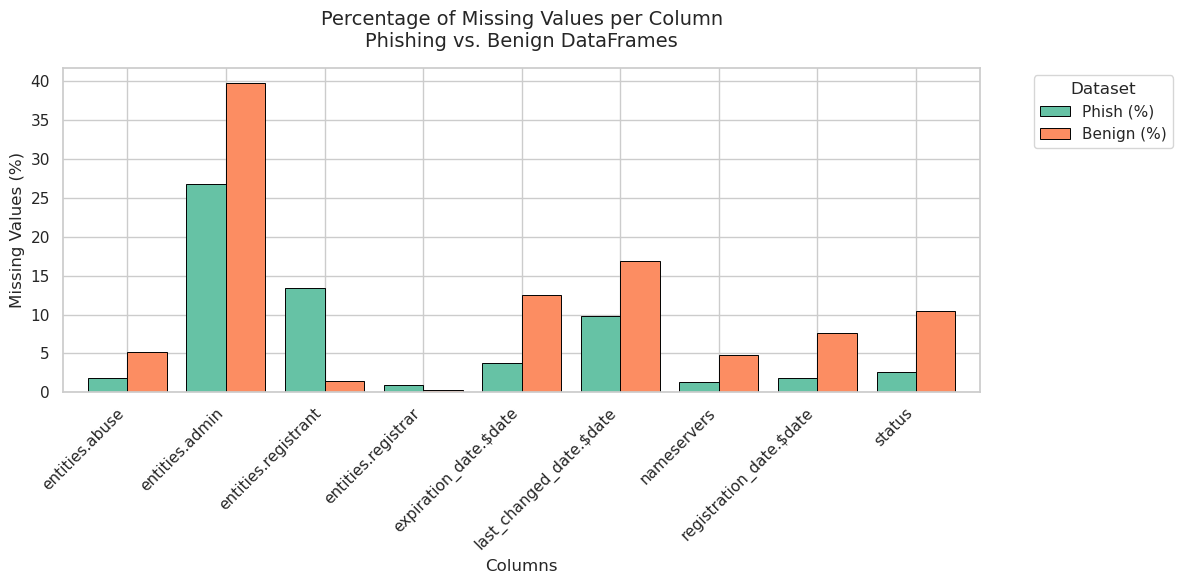

In [29]:
# 1. Calculate the proportion (percentage) of missing values per column
phish_missing_pct = phish_df.isna().sum() / len(phish_df) * 100
benign_missing_pct = benign_df.isna().sum() / len(benign_df) * 100

# 2. Combine into one DataFrame
missing_pct = pd.DataFrame({
    'Phish (%)': phish_missing_pct,
    'Benign (%)': benign_missing_pct
})

# 3. (Optional) Filter to only columns that have missing values in at least one DataFrame
missing_pct = missing_pct[(missing_pct['Phish (%)'] > 0) | (missing_pct['Benign (%)'] > 0)]

# 4. Set a modern Seaborn theme
sns.set_theme(style="whitegrid")

# 5. Plot a grouped bar chart
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)
ax = missing_pct.plot(
    kind='bar',
    color=colors,
    width=0.8,
    edgecolor='black',
    linewidth=0.7,
    figsize=(12, 6)
)

# 6. Customize the title and labels
ax.set_title("Percentage of Missing Values per Column\nPhishing vs. Benign DataFrames", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Values (%)", fontsize=12)

# 7. Improve x-axis label rotation
plt.xticks(rotation=45, ha='right')

# 8. Move the legend (optional)
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

# 9. Tight layout for readability
plt.tight_layout()

# 10. Display the plot
plt.show()


In [30]:
print(phish_df["entities.abuse"].value_counts())
print(benign_df["entities.abuse"].value_counts())

entities.abuse
[{'email': ''}]                                                                                                       110435
[{'handle': 'FFBA2ECCF7E1438E9DDC9D520FE1BD1F-DONUTS', 'type': 'entity', 'email': 'abuse@support.gandi.net'}]           5801
[{'type': 'entity', 'name': '', 'email': ''}]                                                                           3128
[{'type': 'entity', 'email': 'tldsupport@cscinfo.com'}]                                                                 2844
[{'type': 'entity', 'name': '', 'email': 'abuse@godaddy.com'}]                                                          2037
                                                                                                                       ...  
[{'type': 'entity', 'name': '', 'email': 'abuse@infomaniak.com'}]                                                          1
[{'type': 'entity', 'name': 'Abuse contact', 'tel': '01225-965999', 'email': 'abuse@verpex.com'}]             

## Prepare the dataframe for trasnformer training
For training the transformer, it is neccessary to create a one concatenated string with fields from analyzed dataframe

In [31]:
def stringify_value(value):
    if isinstance(value, dict):
        return json.dumps(value)
    return str(value) if value else "NA"

def format_entity_entry(entry, canonical_keys):
    kv_pairs = []
    for key in canonical_keys:
        value = entry.get(key, "NA")
        value_str = stringify_value(value)
        if not value_str or value_str == "":
            value_str = "NA"
        kv_pairs.append(f"{key}: {value_str}")
    return " | ".join(kv_pairs)

def process_entity_field(entity_list, canonical_keys, field_label):
    if not entity_list or not isinstance(entity_list, list):
        return f"{field_label}: NA"
    formatted_entries = [format_entity_entry(entry, canonical_keys) for entry in entity_list]
    return f"{field_label}: " + " ; ".join(formatted_entries)

def process_list_field(values, field_label, separator=", "):
    if not values or not isinstance(values, list) or len(values) == 0:
        return f"{field_label}: NA"
    cleaned_values = [str(value).strip() for value in values if value]
    if not cleaned_values:
        return f"{field_label}: NA"
    return f"{field_label}: " + separator.join(cleaned_values)

def concat_rdap_fields(row):
    CLS_TOKEN = "[CLS]"
    SEP_TOKEN = "[SEP]"
    
    tokens = []
    
    # Process the domain_name field.
    domain = row.get("domain_name", "NA").lower().lstrip("www.")
    tokens.append(f"domain: {domain}")
    
    # Define canonical keys for entity fields.
    abuse_keys      = ['name', 'type', 'email', 'url', 'tel', 'handle']
    registrar_keys  = ['name', 'email', 'whois_server', 'url', 'tel', 'handle', 'type']
    registrant_keys = ['name', 'email', 'whois_server', 'url', 'rir', 'tel', 'handle', 'type']
    admin_keys      = ['name', 'email', 'handle', 'type']
    
    # Process dictionary-based entity fields.
    tokens.append(process_entity_field(row.get("entities.abuse", []), abuse_keys, "abuse"))
    tokens.append(process_entity_field(row.get("entities.registrar", []), registrar_keys, "registrar"))
    tokens.append(process_entity_field(row.get("entities.registrant", []), registrant_keys, "registrant"))
    tokens.append(process_entity_field(row.get("entities.admin", []), admin_keys, "admin"))
    
    # Process list-based fields.
    tokens.append(process_list_field(row.get("nameservers", []), "nameservers"))
    tokens.append(process_list_field(row.get("status", []), "status"))
    
    concatenated = f"{CLS_TOKEN} " + f" {SEP_TOKEN} ".join(tokens) + f" {SEP_TOKEN}"
    return concatenated

# Process each dataframe: apply the concatenation function to create an input string.
benign_df['input_string'] = benign_df.apply(concat_rdap_fields, axis=1)
phish_df['input_string'] = phish_df.apply(concat_rdap_fields, axis=1)

# Now, create a combined dataframe with only the columns needed for training.
# Assume each dataframe already contains the 'label' column.
combined_df = pd.concat(
    [benign_df[['input_string', 'label']], phish_df[['input_string', 'label']]],
    ignore_index=True
)

# Optionally, shuffle the combined DataFrame.
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display a few rows of the resulting DataFrame.
render_dataframe(combined_df)


,input_string,label
0,"[CLS] domain: instagraamloginn.blogspot.com [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: MarkMonitor Inc. | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: Google LLC | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: name: NA | email: NA | handle: NA | type: NA [SEP] nameservers: NS1.GOOGLE.COM, NS2.GOOGLE.COM, NS3.GOOGLE.COM, NS4.GOOGLE.COM [SEP] status: client delete prohibited, client transfer prohibited, client update prohibited, server delete prohibited, server transfer prohibited, server update prohibited [SEP]",1
1,"[CLS] domain: cuevana3.promo [SEP] abuse: name: NA | type: entity | email: abuse@namecheap.com | url: NA | tel: NA | handle: 10AF0F41201E4614A3B8939BABA4BDF2-DONUTS [SEP] registrar: name: NameCheap, Inc. | email: NA | whois_server: NA | url: https://rdap.donuts.co/rdap/entity/1068 | tel: NA | handle: 1068 | type: entity [SEP] registrant: name: Privacy service provided by Withheld for Privacy ehf | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: entity [SEP] admin: NA [SEP] nameservers: kay.ns.cloudflare.com, kanye.ns.cloudflare.com [SEP] status: client transfer prohibited [SEP]",0
2,"[CLS] domain: majoranaiiss.edu.it [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: Aruba s.p.a. | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: I.I.S.S. E.Majorana | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: name: NA | email: NA | handle: NA | type: NA [SEP] nameservers: DNS.TECHNORAIL.COM, DNS2.TECHNORAIL.COM, DNS3.ARUBADNS.NET, DNS4.ARUBADNS.CZ [SEP] status: ok [SEP]",0
3,"[CLS] domain: rbmoto.lv [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: NA | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: NA | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: name: NA | email: NA | handle: NA | type: NA [SEP] nameservers: NS1.AREAIT.LV, NS2.AREAIT.LV [SEP] status: active [SEP]",0
4,"[CLS] domain: co.jp-admin.xrwcma.cn [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: 阿里云计算有限公司（万网） | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: 陆惠普 | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: name: NA | email: NA | handle: NA | type: NA [SEP] nameservers: DNS29.HICHINA.COM, DNS30.HICHINA.COM [SEP] status: ok [SEP]",1
5,"[CLS] domain: blade2.vienna-rack412.nodes.gen4.ninja [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: Gandi SAS | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: CyberGhost SA | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: name: NA | email: NA | handle: NA | type: NA [SEP] nameservers: NS1.GEN4.NINJA, NS2.GEN4.NINJA, NS3.GEN4.NINJA [SEP] status: client transfer prohibited [SEP]",0
6,"[CLS] domain: bellsouthverification-cf9bf2.webflow.io [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: MarkMonitor Inc. | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: Webflow, Inc | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: name: NA | email: NA | handle: NA | type: NA [SEP] nameservers: NS-135.AWSDNS-16.COM, NS-1481.AWSDNS-57.ORG, NS-1541.AWSDNS-00.CO.UK, NS-828.AWSDNS-39.NET [SEP] status: client delete prohibited, client transfer prohibited, client update prohibited [SEP]",1
7,"[CLS] domain: nnfjc.

In [32]:
# combined_df.info()
# save_path = project_root / "datasets" / "phishing" / "rdap_phishing_preprocessed.csv"
# combined_df.to_csv(save_path, index=False)


In [33]:
# save_path = project_root / "datasets" / "malware" / "rdap_malware_preprocessed.csv"
# combined_df.to_csv(save_path, index=False)

In [34]:
max_length = combined_df['input_string'].str.len().max()
print(max_length)

2596
